# Variational Autoencoders using Kpop Idol Faces dataset

Goal: train VAE on the [Kpop Idol Faces](https://www.kaggle.com/datasets/rossellison/kpop-idol-faces) dataset

>[Variational Autoencoders using CelebA Faces dataset](#scrollTo=ZROsKEU-fy4T)

>>[Libraries and Packages](#scrollTo=PcaSvHZsf_xi)

>>>>[Helper functions](#scrollTo=MoOnroVHgSqU)

>>[Parameters](#scrollTo=5EMkiG-Jg07G)

>>[Prepare Data](#scrollTo=zAKEcvQIg-xS)

>>>[Mount google drive](#scrollTo=KF0UTviM3it3)

>>>[Download dataset](#scrollTo=qCnguIEz3ltG)

>>>[Loading and preprocessing the dataset](#scrollTo=iO6cInaO3abL)

>>[Build the Variational Autoencoder (VAE)](#scrollTo=cgystoZVkoVW)

>>>[Sampling Layer](#scrollTo=6MDkvdUn30Rf)

>>>[Encoder](#scrollTo=J8Ix08qZ325G)

>>>[VAE](#scrollTo=FrI5d2tB4Zvs)

>>[Train VAE](#scrollTo=zEg7oyvQlBb5)

>>>[Load Previous Model](#scrollTo=xMmvgVdV6WhB)

>>>[Training run](#scrollTo=us8yL1BZ6ZyN)

>>>[Saving the Model](#scrollTo=fy3zFLEvlgyq)

>>[Reconstruct using VAE](#scrollTo=c4VVnrWslm0g)

>>[Latent space distribution](#scrollTo=54b3Yf-HlxJo)

>>[Generate new faces](#scrollTo=JVzqAMowl2EZ)

>>>[Generate one image](#scrollTo=YsP7MZlPtjEm)

>>[Manipulate the images](#scrollTo=C1T-y3ogmCsP)

>>>[Sampling latent points](#scrollTo=wbRdTirGnejE)

>>>[Visualize Morhphing process](#scrollTo=QYHqUU2gqnkS)

>>>[Disregard for now](#scrollTo=N2mYYr-BcCwJ)



## Libraries and Packages

In [ ]:
%load_ext autoreload
%autoreload 2
#!pip install plotly
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd
from tqdm.notebook import tqdm

#### Helper functions

In [ ]:
def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

# To exract single batch from a Tensorflow dataset
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

# To display a set of images in a grid format
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## Parameters

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## Prepare Data

We are going to be using the CelebA dataset from Kaggle which can be [downloaded here](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). Alternately you can also use the Kaggle API shown here, which will save the dataset on a specific path. Note that this involves registering for a Kaggle account and downloading a .json file that will be used for authorization. Downloading and extracting big datasets will take some time.

### Mount google drive

In [ ]:
from google.colab import drive, files
import os
import zipfile
from zipfile import ZipFile

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download dataset

Specify drive path on the form below. This is where the dataset will reside. If dataset is not on the path, the code below will prompt you for the kaggle json file for authorization and download + extract dataset on specified path.

In [ ]:
# Specify the drive path where you want to save the dataset
dataset_path_in_drive = '/content/drive/MyDrive/ML_experiments/kpop_idol_faces'  # @param{type:"string"}
os.makedirs(dataset_path_in_drive, exist_ok=True)

# Check if the dataset has already been extracted
dataset_already_extracted = os.path.isdir(os.path.join(dataset_path_in_drive, "kpop_idol_faces"))  # Adjust based on actual extracted content

if not dataset_already_extracted:
    # Prompt user to upload kaggle.json for Kaggle API authentication
    uploaded = files.upload()

    # Assuming kaggle.json was uploaded, set up Kaggle directory and permissions
    kaggle_json_path = '/content/kaggle.json'  # Default path where the uploaded file is saved
    if 'kaggle.json' in uploaded:
        !mkdir -p ~/.kaggle
        !cp {kaggle_json_path} ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        raise ValueError("kaggle.json not uploaded. Please upload your Kaggle API token.")

    # Install Kaggle API
    !pip install kaggle

    # Download dataset from Kaggle
    kaggle_dataset = 'rossellison/kpop-idol-faces'  # Replace with the dataset you want to download
    !kaggle datasets download -d {kaggle_dataset} -p "{dataset_path_in_drive}"

    # Define the path to the zip file and the extraction path
    zip_file_path = os.path.join(dataset_path_in_drive, f"{kaggle_dataset.split('/')[-1]}.zip")
    extraction_path = dataset_path_in_drive

    # Use zipfile to open the archive and find the number of items
    with ZipFile(zip_file_path, 'r') as zip_ref:
        items = zip_ref.infolist()  # Get a list of archive members
        total_length = len(items)  # Total number of items to extract

        # Setup tqdm (or another progress bar library) for visual progress
        with tqdm(total=total_length, unit='file', desc="Extracting files") as pbar:
            for item in items:
                zip_ref.extract(member=item, path=extraction_path)  # Extract each item
                pbar.update(1)  # Update the progress bar by one unit per file

    print("Extraction completed.")

    # Optionally, remove the zip file to save space
    os.remove(zip_file_path)
else:
    print("Dataset already extracted.")

Saving kaggle.json to kaggle.json
100% 3.49G/3.49G [00:55<00:00, 47.1MB/s]
100% 3.49G/3.49G [00:55<00:00, 67.6MB/s]


Extracting files:   0%|          | 0/4482 [00:00<?, ?file/s]

Extraction completed.


### Loading and preprocessing the dataset

In [ ]:
# Load the data + preprocess (normalization and prefetching)
train_data = utils.image_dataset_from_directory(
    dataset_path_in_drive,  # dataset above
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
).map(lambda x: (x / 255.0)).prefetch(tf.data.AUTOTUNE)

train = train_data

Found 4482 files belonging to 1 classes.


In [ ]:
train_sample = sample_batch(train)

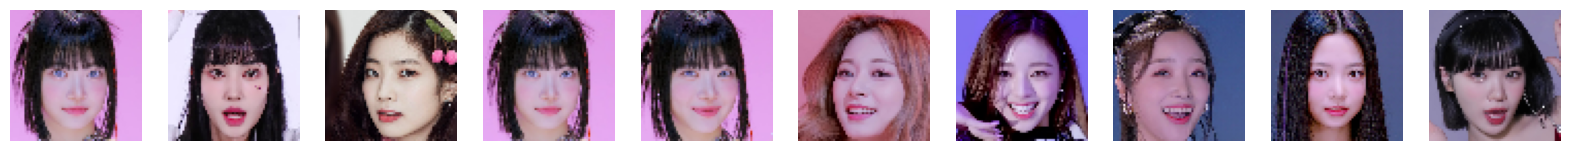

In [ ]:
# Show some faces from the training set
display(train_sample, cmap=None)

## Build the Variational Autoencoder (VAE)

### Sampling Layer

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          36928     
 anspose)                                                    

### VAE

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def get_config(self):
        config = super(VAE, self).get_config()
        # This approach assumes encoder and decoder have get_config methods.
        # If not, you might need to manually specify their configurations.
        config.update({
            'encoder': self.encoder.get_config(),
            'decoder': self.decoder.get_config(),
        })
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        # Here, you need to reconstruct the encoder and decoder from their configs.
        # This might involve using their respective from_config methods if available,
        # or reconstructing them directly if you know their classes.
        encoder = tf.keras.models.Model.from_config(config['encoder'], custom_objects=custom_objects)
        decoder = tf.keras.models.Model.from_config(config['decoder'], custom_objects=custom_objects)
        return cls(encoder=encoder, decoder=decoder, **config)

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## Train VAE

In [ ]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/ML_experiments/kpop_idol_faces/Checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim, output_dir='./output'):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir
        # Ensure the output directory exists
        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save(os.path.join(self.output_dir, f'generated_img_{epoch:03d}_{i}.png'))

### Load Previous Model (if applicable)

In [ ]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

### Training run

In [ ]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
36/36 [==============================] - 90s 1s/step - loss: 229.9041 - reconstruction_loss: 154.5989 - kl_loss: 24.3313
Epoch 2/10
36/36 [==============================] - 74s 2s/step - loss: 116.4453 - reconstruction_loss: 99.2804 - kl_loss: 11.8979
Epoch 3/10
36/36 [==============================] - 69s 2s/step - loss: 100.3420 - reconstruction_loss: 85.5595 - kl_loss: 12.8905
Epoch 4/10
36/36 [==============================] - 71s 2s/step - loss: 96.5794 - reconstruction_loss: 80.5051 - kl_loss: 15.0728
Epoch 5/10
36/36 [==============================] - 72s 2s/step - loss: 91.5386 - reconstruction_loss: 78.0538 - kl_loss: 13.2290
Epoch 6/10
36/36 [==============================] - 64s 1s/step - loss: 90.9504 - reconstruction_loss: 77.4347 - kl_loss: 14.1201
Epoch 7/10
36/36 [==============================] - 71s 2s/step - loss: 88.1973 - reconstruction_loss: 75.3433 - kl_loss: 12.9937
Epoch 8/10
36/36 [==============================] - 73s 2s/step - loss: 87.5576 - reco

### Saving the Model


In [ ]:
# Base directory path in Google Drive
drive_base_path = '/content/drive/MyDrive/ML_experiments/kpop_idol_faces/Models'

# Specific model save paths
model_save_path = os.path.join(drive_base_path, "VAE_Kpop_Idol_Models")
vae_save_path = os.path.join(model_save_path, "vae")
encoder_save_path = os.path.join(model_save_path, "encoder")
decoder_save_path = os.path.join(model_save_path, "decoder")

# Ensure the model directories exist
os.makedirs(vae_save_path, exist_ok=True)
os.makedirs(encoder_save_path, exist_ok=True)
os.makedirs(decoder_save_path, exist_ok=True)

# Save the final models
vae.save(vae_save_path)
encoder.save(encoder_save_path)
decoder.save(decoder_save_path)

## Reconstruct using VAE

In [ ]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

In [ ]:
def display_comparison(original, reconstructed, n=10):
    # Ensuring n does not exceed the batch size
    n = min(n, original.shape[0])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].astype("float32"))  # Ensuring correct data type
        plt.title("Original")
        plt.axis("off")

        # Plot reconstructed image
        ax = plt.subplot(2, n, n + i + 1)  # Adjusted index for placing reconstructed images
        plt.imshow(reconstructed[i].astype("float32"))  # Ensuring correct data type
        plt.title("Reconstructed")
        plt.axis("off")

    plt.show()


4/4 [==============================] - 1s 7ms/step
Example real faces vs. Reconstructions


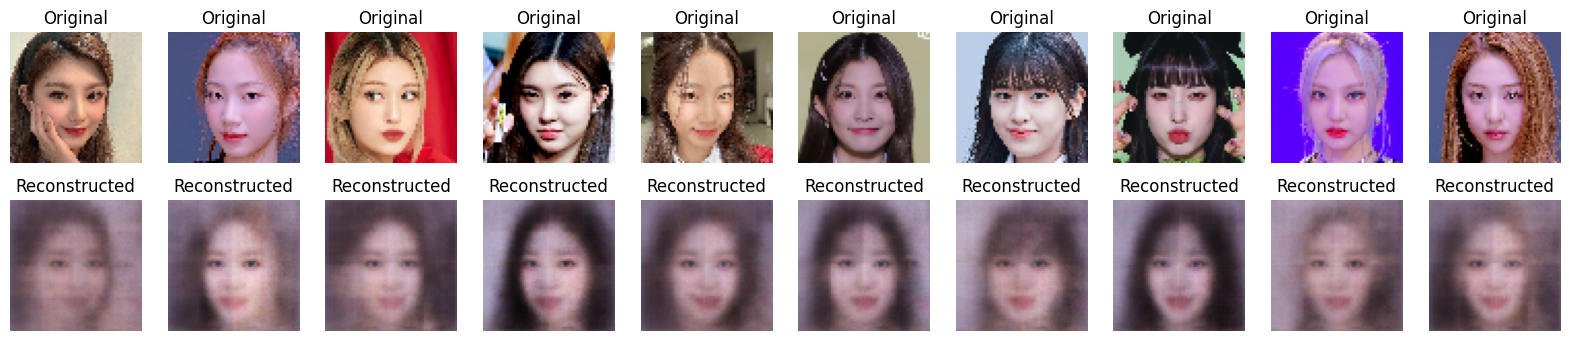

In [ ]:
# Assuming 'example_images' is your subset of original images and
_, _, reconstructions = vae.predict(example_images)

# Adjust this as needed based on the actual number of images you want to display
num_images_to_display = 10

# Ensure the images are numpy arrays for visualization
# This step might be redundant if they are already in the correct format
example_images_np = example_images.numpy() if hasattr(example_images, 'numpy') else example_images
reconstructions_np = reconstructions.numpy() if hasattr(reconstructions, 'numpy') else reconstructions

# Call the enhanced display function
print("Example real faces vs. Reconstructions")
display_comparison(example_images_np, reconstructions_np, n=num_images_to_display)

## Latent space distribution

4/4 [==============================] - 0s 4ms/step


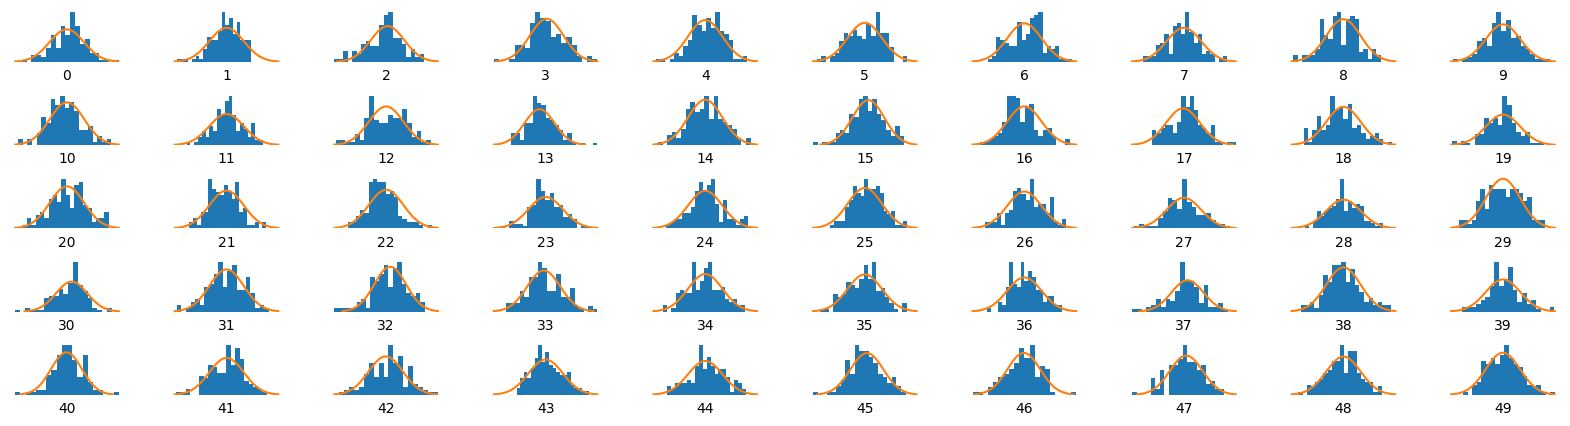

In [ ]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## Generate new faces

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 1s 645ms/step


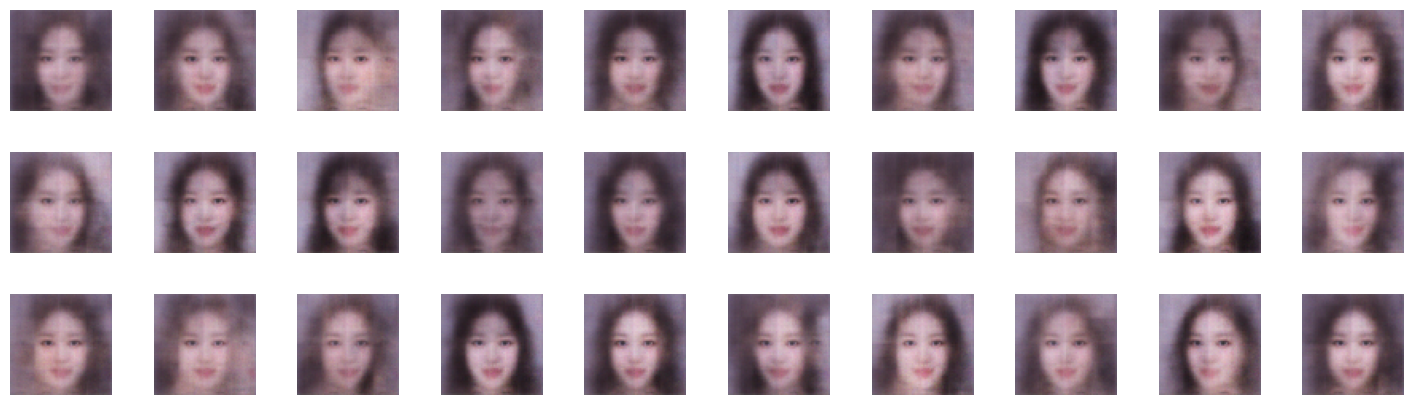

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## Manipulate the images

### Sampling latent points

In [ ]:
z_dim = Z_DIM  # Dimension of the latent space
z_sample1 = np.random.normal(size=(1, z_dim))
z_sample2 = np.random.normal(size=(1, z_dim))


In [ ]:
#Interpolating between Latent Points
def linear_interpolate(z_start, z_end, num_steps=10):
    interpolated = np.zeros((num_steps+1, z_start.shape[1]))
    for step in range(num_steps + 1):
        alpha = step / float(num_steps)
        interpolated[step] = z_start * (1 - alpha) + z_end * alpha
    return interpolated

z_interpolated = linear_interpolate(z_sample1, z_sample2, num_steps=10)


In [ ]:
#Decode the interpolated points
morphed_images = vae.decoder.predict(z_interpolated)


1/1 [==============================] - 0s 19ms/step


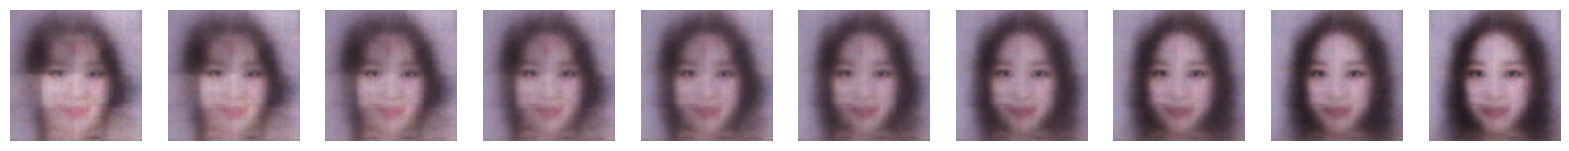

In [ ]:
display(morphed_images, n=10)

### Visualize Morhphing process

In [ ]:
# Assume morphed_images is a batch of images with shape (num_images, height, width, channels)
# and you want to resize them to 1024x1024
morphed_images_resized = tf.image.resize(morphed_images, [1024, 1024], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# Convert resized images to uint8 format for GIF creation
morphed_images_resized_uint8 = (morphed_images_resized * 255).numpy().astype(np.uint8)


import imageio

# Create a GIF file
gif_path = 'morphing.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.1) as writer:  # Adjust duration for each frame as needed
    for image in morphed_images_resized_uint8:
        writer.append_data(image)

print(f"GIF saved to {gif_path}")


GIF saved to morphing.gif


Expanding the range of interpolation

In [ ]:
num_steps = 100

def extended_linear_interpolate(z_start, z_end, num_steps=100, extend_factor=0.4):
    interpolated = np.zeros((num_steps + 1, z_start.shape[1]))
    for step in range(num_steps + 1):
        # Adjust alpha to extend beyond the start and end points
        alpha = step / float(num_steps)
        alpha = (alpha * (1 + 2 * extend_factor)) - extend_factor  # Extend the interpolation range
        interpolated[step] = z_start * (1 - alpha) + z_end * alpha
    return interpolated

z_interpolated = extended_linear_interpolate(z_sample1, z_sample2, num_steps, extend_factor=0.4)


In [ ]:
morphed_images = vae.decoder.predict(z_interpolated)

# Convert to uint8 format for GIF creation
morphed_images_uint8 = (morphed_images * 255).astype(np.uint8)

# Create the GIF
import imageio

gif_path = 'extended_morphing.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.05) as writer:  # Adjust duration as needed
    for image in morphed_images_uint8:
        writer.append_data(image)

print(f"Extended morphing GIF saved to {gif_path}")


4/4 [==============================] - 0s 70ms/step
Extended morphing GIF saved to extended_morphing.gif


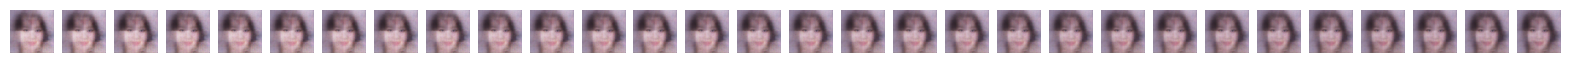

In [ ]:
display(morphed_images, n=30)

### Notes:
- Since the dataset didn't come with attribute labels, it would be challenging to visualize morphing the faces through attributes alone. A separate technique needs to be done to extract the facial attributes of the images which is out of scope for this notebook.
- The dataset was organized by band names which can be used as labels but doing so would not yield interesting visualization of how one attribute vector shifts to the next. Band names as labels don't hold enough information that can represent certain styles or common features.